# Simulate the motion of a levitated nanoparticle in free fall measurement with Monte-Carlo method.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# costomized
from physics_constant import Physics_Constant
const = Physics_Constant()
from helpers import *

# Define parameters

In [2]:
# experiment measured data
torque_sensitivity_0 = 5e-26 # Nm
pressure_0 = 6e-5 # Torr
tau_0 = 4 # s
torque_casimir = 1.4e-24 # Nm
radius = 72e-9 # m
M = cal_mass_dumbbell(radius, const.rho_silica)
I = cal_I_dumbbell(radius, const.rho_silica)

# define parameters for librational motion
f_0_theta = 1e6 # eigen frequency
omage_0_theta = 2*np.pi * f_0_theta # angular frequency
theta_0 = np.pi/4 # initial angular position where the torque is maximum.

# define parameters for monte-carlo simulation
dt = 2e-9 # delta t for each iteration
N = 500 # number of trajectories 
pressure = 6e-5 # Torr

# helper functions

In [3]:
def cal_torque_sensitivity(pressure):
    return torque_sensitivity_0 * (pressure/pressure_0)**0.5


def cal_tau(pressure):
    return tau_0/(pressure/pressure_0)


def cal_gamma(pressure):
    return 1/cal_tau(pressure)


Gamma = cal_gamma(pressure)
Tau = cal_tau(pressure)
Torque_sensitivity = cal_torque_sensitivity(pressure)

print("pressure:", pressure, "Torr \n",  
      "Gamma:", Gamma, "Hz \n", 
      "Tau:", Tau, "s \n" 
      "Torque Sensitivity:", Torque_sensitivity, "Nm/Hz^0.5")

def cal_torque_casimir_angle(theta):
    """
    sin(2*theta)
    """

    return -torque_casimir * np.sin(2*theta)


def pulse_laser():
    """
    unit
    """
    pulse1 = np.ones(int(6e-5/dt))
    pulse2 = np.zeros(int(2e-5/dt))
    pulse3 = np.ones(int(2e-5/dt))
    pulse4 = np.ones(int(6e-5/dt))

    return np.hstack((pulse1, pulse2, pulse3, pulse4))


def pulse_fb(fb_factor):
    """
    unit
    """
    pulse1 = fb_factor*np.ones(int(6e-5/dt))
    pulse2 = np.zeros(int(2e-5/dt))
    pulse3 = np.zeros(int(2e-5/dt))
    pulse4 = fb_factor*np.ones(int(6e-5/dt))

    return np.hstack((pulse1, pulse2, pulse3, pulse4))


def angular_vel_0():
    return (const.kB * const.T0 / I)**0.5 * np.random.randn(1, N)


def angular_pos_0():
    return (const.kB * const.T0 / (I * omage_0_theta**2))**0.5 * np.random.randn(1, N) + np.pi/4


def angular_random_acce():
    """
    in the torsional equation
    """

    return (2 * const.kB * const.T0 * Gamma / (I * dt))**0.5 * np.random.randn(1, N)


def angular_optical_acce(angular_pos):
    """
    in the torsional equation
    """

    return -omage_0_theta**2 * (np.sin(2 * (angular_pos - theta_0)) / 2)


def angular_acce(angular_pos, angular_vel, laser_power, fb):
    """
    in the torsional equation
    """

    return angular_random_acce() \
           - fb*angular_vel \
           - Gamma*angular_vel \
           + angular_optical_acce(angular_pos)*laser_power \
           + cal_torque_casimir_angle(angular_pos)/I


def angle_vs_time(time_input):
    time_input = time_input -time_input[0] # interesting thing about python 
    angle_p_arr = np.ones_like(time_input)*np.pi/4
    angle_v_arr = np.zeros_like(time_input)
    
    dt = time_input[1] - time_input[0]
    for i in range(len(time_input)-1):
        angle_a = cal_torque_casimir_angle(angle_p_arr[i])/I        
        angle_v_arr[i+1] = angle_v_arr[i] + dt*angle_a
        angle_p_arr[i+1] = angle_p_arr[i] + dt*angle_v_arr[i]
        
    return angle_p_arr

pressure: 6e-05 Torr 
 Gamma: 0.25 Hz 
 Tau: 4.0 s 
Torque Sensitivity: 5e-26 Nm/Hz^0.5


# Monte-Carlo Simulation with parallel programming

100%|█████████████████████████████████████████████████████████████████████| 79999/79999 [00:10<00:00, 7695.91it/s]


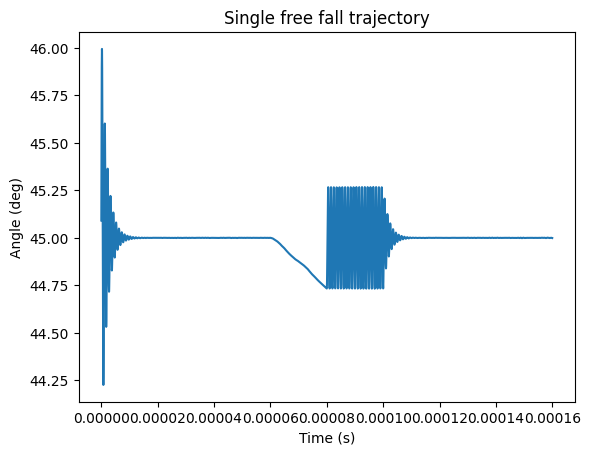

In [4]:
sequence_laser = pulse_laser()
sequence_fb = pulse_fb(1e6)
sequence_t = dt*np.linspace(0, len(sequence_laser), len(sequence_laser))

# define variables initial state
angle_pos = np.zeros((len(sequence_laser), N)) 
angle_pos[0] = angular_pos_0()
angle_vel = np.zeros((len(sequence_laser), N))
angle_vel[0] = angular_vel_0()

for i in tqdm(range(len(sequence_laser)-1)):
    
    x = angle_pos[i]
    v_x = angle_vel[i]
    fb = sequence_fb[i]
    laser_power = sequence_laser[i]

    # runge-kutta methods for differential equations
    k1_x=dt * v_x;
    l1_x=dt * angular_acce(x, v_x, laser_power, fb)
    
    k2_x=dt * (v_x + l1_x/2)
    l2_x=dt * angular_acce(x + k1_x/2, v_x + l1_x/2, laser_power, fb)
    
    k3_x=dt * (v_x + l2_x/2)
    l3_x=dt * angular_acce(x + k2_x/2, v_x + l2_x/2, laser_power, fb)
    
    k4_x=dt * (v_x + l3_x)
    l4_x=dt * angular_acce(x + k3_x, v_x + l3_x, laser_power, fb)

    # step i -> step i+1
    angle_pos[i+1] = angle_pos[i]   + (k1_x + 2*k2_x + 2*k3_x + k4_x)/6
    angle_vel[i+1] = angle_vel[i] + (l1_x + 2*l2_x + 2*l3_x + l4_x)/6
    
    
plt.figure()
plt.plot(sequence_t, angle_pos[:,0]/np.pi*180)
plt.title("Single free fall trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.show()

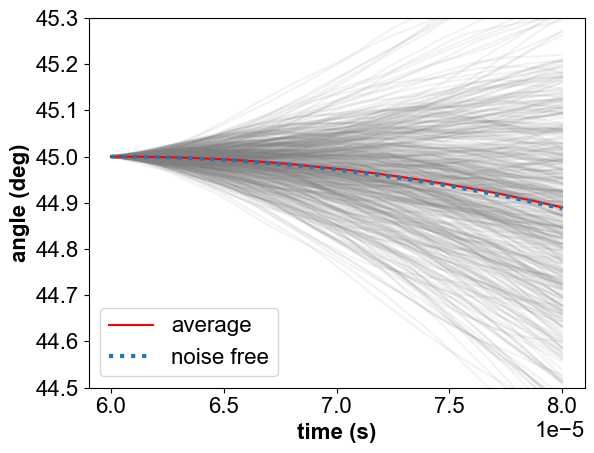

In [5]:
ftsize = 16
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.labelweight'] = 'bold'

t_freefall = 6e-5 # s
t_freefall_index = int(t_freefall/dt)

plt.figure()
plt.plot(sequence_t[t_freefall_index:t_freefall_index+10000], 
         angle_pos[t_freefall_index:t_freefall_index+10000]/np.pi*180, "#808080", 
         alpha=0.1)

plt.plot(sequence_t[t_freefall_index:t_freefall_index+10000], 
         np.mean(angle_pos[t_freefall_index:t_freefall_index+10000], axis = 1)/np.pi*180, 
         "r", label = "average")

plt.plot(sequence_t[t_freefall_index:t_freefall_index+10000], 
         angle_vs_time(sequence_t[t_freefall_index:t_freefall_index+10000])*180/np.pi, 
         linestyle= ":",
         linewidth=3,
         label = "noise free")

plt.legend()
plt.xlabel("time (s)")
plt.ylabel("angle (deg)")
plt.ylim(45-0.5, 45+0.3)
plt.show()

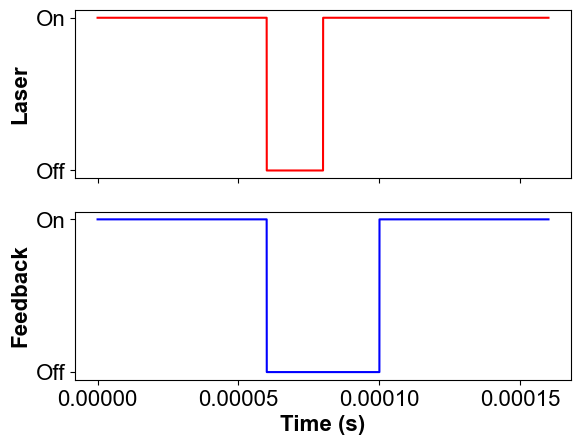

In [6]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(sequence_t, pulse_laser(), "r")
axs[0].xaxis.set_tick_params(labelbottom=False)
axs[0].set_ylabel("Laser")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Off", "On"])

axs[1].plot(sequence_t, pulse_fb(1), "b")
axs[1].set_ylabel("Feedback")
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(["Off", "On"])
axs[1].set_xlabel("Time (s)")

plt.show()

In [7]:
# Save data
os.chdir("./data")

np.savetxt("sequence_tt.csv", sequence_t[t_freefall_index:t_freefall_index+10000], delimiter=",")
np.savetxt('trajectory_ave.csv', np.mean(angle_pos[t_freefall_index:t_freefall_index+10000], axis = 1)/np.pi*180, delimiter=",") 
np.savetxt('trajectory_NoNoise.csv', angle_vs_time(sequence_t[t_freefall_index:t_freefall_index+10000])*180/np.pi, delimiter=",")